In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
df_rating = pd.read_csv('Books_rating.csv')
df_books = pd.read_csv('books_data.csv')

In [3]:
df_rating.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [4]:
df_books.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [5]:
df_rating.shape, df_books.shape

((3000000, 10), (212404, 10))

In [6]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [7]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [8]:
df_books['publisher'].value_counts()[:20]

publisher
Simon and Schuster                   3454
Penguin                              2825
Routledge                            2394
John Wiley & Sons                    2031
Harper Collins                       1911
Cambridge University Press           1486
Macmillan                            1224
Courier Corporation                  1116
Vintage                              1004
Open Road Media                       983
iUniverse                             929
Houghton Mifflin Harcourt             890
Springer Science & Business Media     886
Random House                          831
Oxford University Press               808
Oxford University Press, USA          739
HarperCollins                         611
Hachette UK                           606
Univ of California Press              585
W. W. Norton & Company                578
Name: count, dtype: int64

In [9]:
df_books['authors'].value_counts()[:20]

authors
['Rose Arny']                                236
['William Shakespeare']                      191
['Library of Congress. Copyright Office']    178
['Agatha Christie']                          142
['Erle Stanley Gardner']                     124
["Louis L'Amour"]                            123
['Charles Dickens']                           89
['Edgar Rice Burroughs']                      85
['Zane Grey']                                 75
['Rudyard Kipling']                           75
['Carolyn Keene']                             71
['Ann M. Martin']                             71
['Mark Twain']                                70
['Isaac Asimov']                              70
['Henry James']                               63
['Joseph Conrad']                             62
['Robert Louis Stevenson']                    62
['Nora Roberts']                              62
['Various']                                   60
['Thomas Hardy']                              56
Name: count,

In [10]:
df_rating.groupby(by='Title').count()['User_id'].sort_values(ascending=False)[:20]

Title
The Hobbit                                                          18237
Pride and Prejudice                                                 17969
Atlas Shrugged                                                      10762
Wuthering Heights                                                    8660
Great Expectations                                                   5675
Mere Christianity                                                    5527
The Picture of Dorian Gray                                           5316
Persuasion                                                           5160
Brave New World                                                      5136
Of Mice and Men                                                      4678
The Great Gatsby                                                     4305
The Giver                                                            3854
The Scarlet Letter A Romance                                         3848
Harry Potter and The Sorcerer's 

In [11]:
df_books['categories'].value_counts()[:20]

categories
['Fiction']                        23419
['Religion']                        9459
['History']                         9330
['Juvenile Fiction']                6643
['Biography & Autobiography']       6324
['Business & Economics']            5625
['Computers']                       4312
['Social Science']                  3834
['Juvenile Nonfiction']             3446
['Science']                         2623
['Education']                       2611
['Cooking']                         2445
['Sports & Recreation']             2267
['Family & Relationships']          2178
['Literary Criticism']              2147
['Music']                           2106
['Medical']                         2079
['Art']                             2054
['Body, Mind & Spirit']             2049
['Language Arts & Disciplines']     2036
Name: count, dtype: int64

In [12]:
df_merged = pd.merge(left=df_rating,right=df_books,on='Title',how='inner')
df_merged.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN


In [13]:
df_merged.groupby(by='publisher').count()['User_id'].sort_values(ascending=False)[:20]

publisher
Penguin                                        107625
Simon and Schuster                              93358
Harper Collins                                  67816
Random House                                    36098
Courier Corporation                             32534
Vintage                                         31968
Mariner Books                                   24775
Macmillan                                       24387
HarperCollins                                   24183
Houghton Mifflin Harcourt                       21556
Penguin UK                                      21425
Bantam                                          19871
Hachette UK                                     19550
John Wiley & Sons                               19400
Ballantine Books                                14173
Library of Alexandria                           13278
Open Road Media                                 13035
W. W. Norton & Company                          11565
Anchor            

In [14]:
df_merged.groupby(by='authors').count()['User_id'].sort_values(ascending=False)[:20]

authors
['Jane Austen']                  32424
['J. R. R. Tolkien']             30572
['Charles Dickens']              17834
['John Steinbeck']               12793
['Lewis Carroll']                11457
['C. S. Lewis']                  10637
['John Ronald Reuel Tolkien']    10062
['Kurt Vonnegut']                 9947
['Emily Bronte']                  9540
['F. Scott Fitzgerald']           8635
['Harper Lee']                    8343
['Charlotte Brontë']              8127
['George Orwell']                 7992
['Aldous Huxley']                 7540
['Ray Bradbury']                  7467
['Agatha Christie']               7412
['Stephen King']                  7197
['Mark Twain']                    6833
['Rey Terciero']                  6499
['Louisa May Alcott']             6164
Name: User_id, dtype: int64

In [15]:
df_rating_sample = df_rating.sample(frac=0.01)

In [16]:
df_rating_sample.shape

(30000, 10)

In [17]:
# from datasets import Dataset

# df_rating_sample.fillna({'review/text':'NA'},inplace=True)
# df_rating_sample = df_rating_sample[['review/text','review/score']]
# df_rating_sample['labels'] = df_rating_sample['review/score'].astype(int) - 1

In [18]:
# dataset = Dataset.from_pandas(df_rating_sample)
# dataset = dataset.train_test_split(test_size=0.2)

In [19]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# def tokenize_fn(example):
#     return tokenizer(example["review/text"], padding="max_length", truncation=True, max_length=128)

# tokenized_ds = dataset.map(tokenize_fn, batched=True)
# tokenized_ds = tokenized_ds.remove_columns(["review/text"])
# tokenized_ds.set_format("torch")

In [20]:
# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

In [21]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     output_dir="./bert-books",
#     eval_strategy="epoch",
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     logging_dir='./logs',
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_ds["train"],
#     eval_dataset=tokenized_ds["test"],
# )

# trainer.train()

In [22]:
# trainer.evaluate()

In [23]:
df_rating_sample.dropna(subset=['Title','User_id'],inplace=True)

In [24]:
df_rating_sample.fillna({'review/summary':'NA'},inplace=True)
df_rating_sample.fillna({'review/text':'NA'},inplace=True)

In [25]:
df_rating_sample.drop(columns=['Id','Price','profileName','review/helpfulness','review/time'],inplace=True)

In [26]:
df_rating_sample['review word count'] = df_rating_sample['review/text'].apply(lambda x:len(x.strip().split(' ')))

(0.0, 500.0)

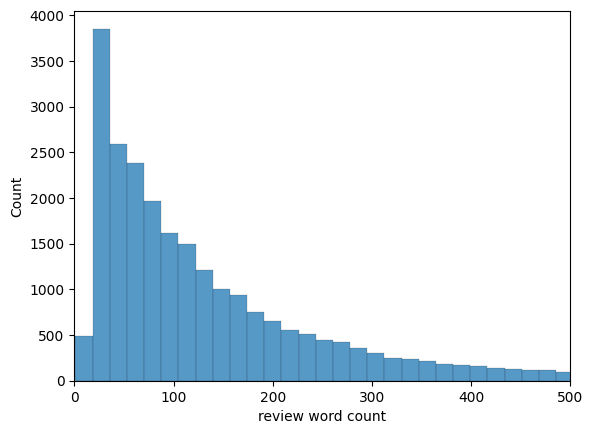

In [27]:
hist = sns.histplot(df_rating_sample['review word count'])
hist.set_xlim([0,500])

In [28]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r'[^A-Za-z0-9\s]','',s)
    s = re.sub(r'\s+',' ',s)
    return s

df_rating_sample['review/text'] = df_rating_sample['review/text'].apply(lambda x:clean_text(x))
# df_rating['review/text'] = df_rating['review/text'].apply(lambda x:clean_text(x))

In [29]:
def pre_process(x):
    x = word_tokenize(x)
    return ' '.join(x)

In [30]:
%%time
df_rating_sample['review/text'] = df_rating_sample['review/text'].apply(lambda x:pre_process(x))
# df_rating['review/text'] = df_rating['review/text'].apply(lambda x:pre_process(x))

CPU times: user 4.84 s, sys: 345 μs, total: 4.84 s
Wall time: 4.85 s


In [31]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(df_rating_sample['review/text'])
y = df_rating_sample['review/score']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [33]:
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train,y_train)
y_predict = lgr.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         1.0       0.55      0.19      0.28       442
         2.0       0.34      0.04      0.06       370
         3.0       0.41      0.12      0.19       609
         4.0       0.42      0.20      0.27      1523
         5.0       0.67      0.95      0.78      4368

    accuracy                           0.63      7312
   macro avg       0.48      0.30      0.32      7312
weighted avg       0.57      0.63      0.56      7312



In [34]:
all_words=set()
for rev in df_rating_sample['review/text']:
    all_words.update(word_tokenize(rev))
all_words = list(all_words)

In [35]:
vocab = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [36]:
df_rating_sample['tokens'] = df_rating_sample['review/text'].apply(lambda x: word_tokenize(x))

In [37]:
def encode_tokens(tokens, vocab, max_len=300):
    ids = [vocab.get(word, vocab['<UNK>']) for word in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab['<PAD>']] * (max_len - len(ids))
    return ids

df_rating_sample['input_ids'] = df_rating_sample['tokens'].apply(lambda x: encode_tokens(x, vocab))

In [38]:
df_rating_sample['review/score'] = df_rating_sample['review/score'].astype(int) - 1

In [39]:
class ReviewDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

X_train, X_val, y_train, y_val = train_test_split(df_rating_sample['input_ids'].tolist(), df_rating_sample['review/score'].tolist(), test_size=0.2, random_state=42)

train_ds = ReviewDataset(X_train, y_train)
val_ds = ReviewDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, num_workers=4, shuffle=True)
val_loader = DataLoader(val_ds, num_workers=4, batch_size=64, shuffle=False)

In [40]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, hidden_dim=256, num_classes=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers = 2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, enforce_sorted=False)
        _, hidden = self.gru(embedded)
        output = self.fc(hidden[-1])  
        return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUClassifier(vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1 - Loss: 2.7633
Epoch 2 - Loss: 2.3782
Epoch 3 - Loss: 2.2500


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(f"Validation Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(classification_report(all_labels, all_preds, target_names=["1", "2", "3", "4", "5"]))